In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [3]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

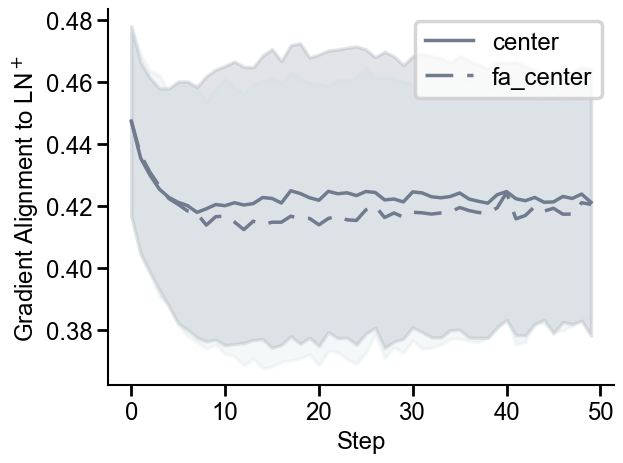

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm, colors

# Truncate bone colormap to avoid white
def truncate_colormap(cmap, minval=0.0, maxval=0.85, n=100):
    return colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Setup
runs_dict = dict()
fig, ax = plt.subplots() #(figsize=(12, 4))
brightness_factors = [0, 0.5, 0.75, 1]
ln_feedback_types = ['center', 'fa_center']

# Use truncated bone colormap
trunc_bone = truncate_colormap(cm.get_cmap('bone'), 0.5, 0.85)
colors_bone = [trunc_bone(i / (len(ln_feedback_types) - 1)) for i in range(len(ln_feedback_types))]

for idx, ln_fdb in enumerate(ln_feedback_types):

    history_fc1_all = []

    for bright in brightness_factors:
        # Fetch runs for a specific brightness factor
        runs_dict["runs_homeostasis"] = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist", 
                "config.brightness_factor": bright,
                "config.homeostasis": 1,
                "config.normtype": 0,
                "config.normtype_detach": 0,
                "config.excitation_training": 1,
                "config.layer_norm": None,
                "config.feedback_alignment": 0,
                "config.ln_feedback": ln_fdb,
                "config.use_testset": True
            },
            order="-summary_metrics.test_acc"
        )

        history_fc1 = []

        for run in runs_dict["runs_homeostasis"]:
            hist_fc1 = run.history(samples=50000, keys=["gradient_alignment_fc1"])

            # Skip runs with string 'NaN'
            if (hist_fc1["gradient_alignment_fc1"].astype(str) == 'NaN').any():
                continue

            history_fc1.append(hist_fc1)

        if history_fc1:  # Only append if non-empty
            history_fc1_all.extend(history_fc1)

    # Skip this ln_fdb condition if no good runs
    if not history_fc1_all:
        continue

    # Stack and average
    data_fc1 = np.stack([df["gradient_alignment_fc1"].astype(float).values for df in history_fc1_all])
    output_mu_fc1 = np.mean(data_fc1, axis=0)
    output_std_fc1 = np.std(data_fc1, axis=0)

    ax.plot(output_mu_fc1, label=ln_fdb, color=colors_bone[0], linestyle='--' if idx == 1 else '-')
    ax.fill_between(
        range(len(output_mu_fc1)),
        output_mu_fc1 - output_std_fc1,
        output_mu_fc1 + output_std_fc1,
        alpha=0.2,
        color=colors_bone[idx]
    )

# Final plot setup
ax.set_xlabel("Step")
ax.set_ylabel("Gradient Alignment to LN$^+$")
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.legend()
plt.tight_layout()
plt.savefig("figure5c.svg", format="svg")

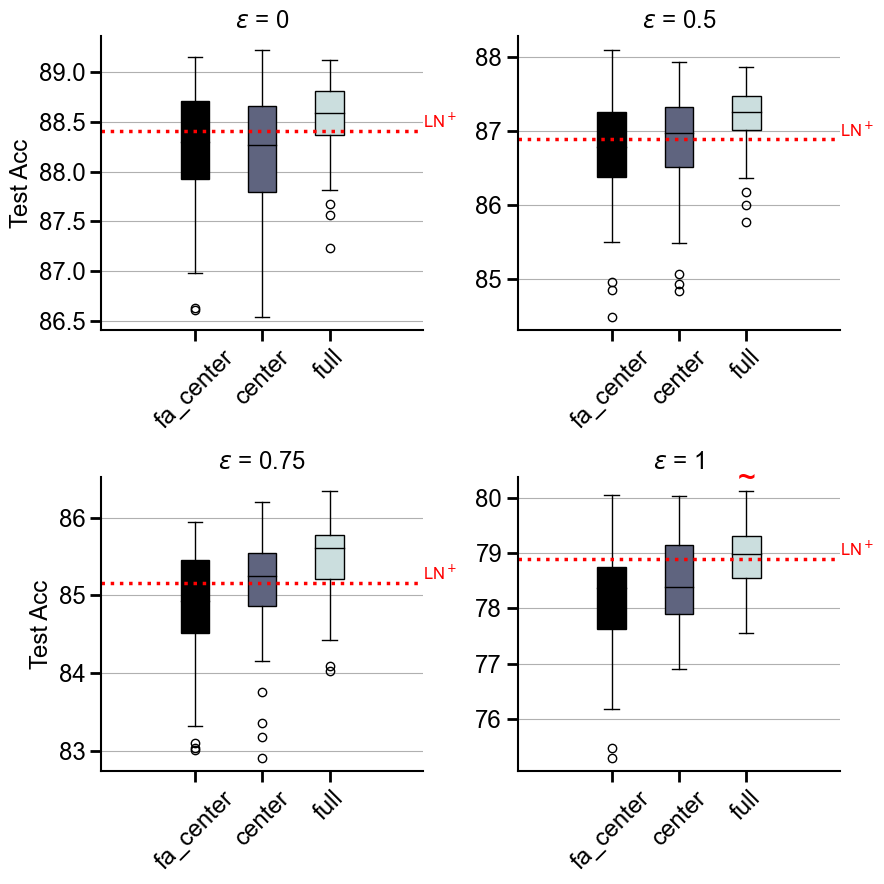

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib import cm, colors

# ---- Configs ----
brightness_factors = [0, 0.5, 0.75, 1]
feedback_types = ['fa_center', 'center', 'full']
bar_width = 0.18
outlier_threshold = 15
median_threshold = 60
indicator_symbol = "~"

# ---- Colormap: Truncated 'bone' ----
def truncate_colormap(cmap, minval=0.0, maxval=0.85, n=100):
    return colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

trunc_bone = truncate_colormap(cm.get_cmap('bone'), 0.0, 0.85)
feedback_colors = {f: trunc_bone(i / (len(feedback_types) - 1)) for i, f in enumerate(feedback_types)}

# ---- Fetch Accuracy Data ----
acc_data = {b: {f: [] for f in feedback_types} for b in brightness_factors}

for bfi in brightness_factors:
    for ln_fdb in feedback_types:
        runs = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bfi,
                "config.homeostasis": 1,
                "config.normtype": 0,
                "config.normtype_detach": 0,
                "config.excitation_training": 1,
                "config.layer_norm": None,
                "config.feedback_alignment": 0,
                "config.ln_feedback": ln_fdb,
                "config.use_testset": True
            },
            order="-summary_metrics.test_acc"
        )
        for run in runs:
            acc = run.summary.get("test_acc", 0.1)
            acc_data[bfi][ln_fdb].append(acc)

# ---- Plotting ----
fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharey=False)
axs = axs.flatten()  # Flatten 2D array for easier indexing
center_offset = (len(feedback_types) - 1) / 2
offset_spacing = 2  # increase for more spacing
offsets = {f: (i - center_offset) * bar_width * offset_spacing for i, f in enumerate(feedback_types)}


for idx, bfi in enumerate(brightness_factors):
    ax = axs[idx]
    x_base = 0
    all_medians = []

    # Get median accuracy for LN and noLN here:

    runs_e_network_ln = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 1, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
    top_n = len(runs_e_network_ln)

    runs_e_network_ln_acc = []

    for top in range(top_n):
        runs_e_network_ln_acc.append(runs_e_network_ln[top].summary['test_acc'])
    runs_e_network_ln_acc = np.median(runs_e_network_ln_acc)

    # runs_ei_network_noln = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
    #                                                         "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
    #                                                         "config.excitation_training": 0, "config.layer_norm": 0, "config.use_testset": True}, order="-summary_metrics.test_acc")

    # top_n = len(runs_ei_network_noln)

    # runs_ei_network_noln_acc = []

    # for top in range(top_n):
    #     runs_ei_network_noln_acc.append(runs_ei_network_noln[top].summary['test_acc'])
    # runs_ei_network_noln_acc = np.median(runs_ei_network_noln_acc)


    for ln_fdb in feedback_types:
        raw_data = acc_data[bfi][ln_fdb]
        if not raw_data:
            continue

        position = x_base + offsets[ln_fdb]
        full_data = np.array(raw_data)
        median = np.median(full_data)
        all_medians.append(median)

        data = full_data
        filtered = False

        if median >= 50:
            extreme_outliers = full_data <= 10
            if np.any(extreme_outliers):
                data = full_data[~extreme_outliers]
                filtered = True

        if len(data) == 0:
            continue  # skip empty box

        ax.boxplot(
            [data],
            positions=[position],
            widths=bar_width * 0.85,
            patch_artist=True,
            boxprops=dict(facecolor=feedback_colors[ln_fdb]),
            medianprops=dict(color='black'),
            showfliers=True
        )

        if filtered:
            max_val = max(data)
            indicator_y = max_val + 0.2
            ax.text(
                position,
                indicator_y,
                indicator_symbol,
                ha='center',
                va='center',
                fontsize=22,
                fontweight='bold',
                color='red'
            )

    ax.axhline(y=runs_e_network_ln_acc, color='red', linestyle='dotted')
    x_max = ax.get_xlim()[1]
    ax.text(x=x_max, y=runs_e_network_ln_acc, s='LN$^+$', va='bottom', ha='left', color='red')
    # ax.axhline(y=runs_ei_network_noln_acc, color='red', linestyle='dotted')
    ax.set_xticks([x_base + offsets[f] for f in feedback_types])
    ax.set_xticklabels(feedback_types, rotation=45)
    ax.set_title(f"$\epsilon$ = {bfi}")
    if idx %2 == 0:
        ax.set_ylabel("Test Acc")
    ax.grid(axis='y', which='both')

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.savefig("figure5b.svg", format="svg")

In [7]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

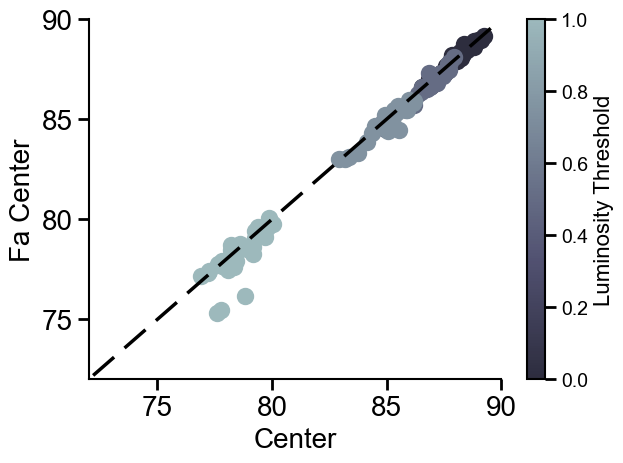

In [8]:
fig, ax = plt.subplots()

# Example brightness factors used
brightness_values = [0, 0.5, 0.75, 1]

# Normalize brightness for colormap mapping
norm = mcolors.Normalize(vmin=min(brightness_values), vmax=max(brightness_values))

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a grayscale colormap from 20% (dark gray) to 100% (black)
cmap = truncate_colormap(plt.get_cmap('bone'), 0.2, 0.7)

scatter_handles = []  # For legend proxy if needed

list_line = range(100)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')
ax.set_xlabel(f"Center", fontsize=20)
ax.set_ylabel("Fa Center", fontsize=20)

for bfi in brightness_values:
    color = cmap(norm(bfi))

    runs_dict = dict()

    runs_dict["runs_homeostasis_fa_center"] = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bfi,
                "config.homeostasis": 1,
                "config.normtype": 0,
                "config.normtype_detach": 0,
                "config.excitation_training": 1,
                "config.layer_norm": None,
                "config.feedback_alignment": 0,
                "config.ln_feedback": 'fa_center',
                "config.use_testset": True
            },
            order="-summary_metrics.test_acc"
        )
    runs_dict["runs_homeostasis_center"] = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bfi,
                "config.homeostasis": 1,
                "config.normtype": 0,
                "config.normtype_detach": 0,
                "config.excitation_training": 1,
                "config.layer_norm": None,
                "config.feedback_alignment": 0,
                "config.ln_feedback": 'center',
                "config.use_testset": True
            },
            order="-summary_metrics.test_acc"
        )

    top_n = len(runs_dict["runs_homeostasis_fa_center"])

    for top in range(top_n):
        vanilla_dann_acc = runs_dict["runs_homeostasis_fa_center"][top].summary['test_acc']
        for rn in runs_dict["runs_homeostasis_center"]:
            if same_config(rn.config, runs_dict["runs_homeostasis_fa_center"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                sc = ax.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color)
                break  # Only label once per brightness group
ax.set_xlim(72, 90)
ax.set_ylim(72, 90)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Luminosity Threshold', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.savefig("figure5d.svg", format="svg")